#EECS 442 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Maithreyan Ganesh, maithgan

__Important__: after you download the .ipynb file, please name it as __\<your_uniqname\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  2.4.1+cu121
Torchvision Version:  0.19.1+cu121
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [3]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab.
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2024-10-09 16:04:50--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.116
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  21.5MB/s    in 25s     

2024-10-09 16:05:16 (20.7 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [4]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient.
!unzip -q data_miniplaces_modified.zip

## 5.1 (a): Build dataloaders for train, val, and test

In [5]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations.

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################
    composed_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),  # Resize the image
        transforms.ToTensor(),                        # Tensor conversion
        transforms.Normalize(mean, std)               # Normalize with mean and std
    ])

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [6]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset)))
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset)))

# of training samples 90000
# of validation samples 10000
# of test samples 10000


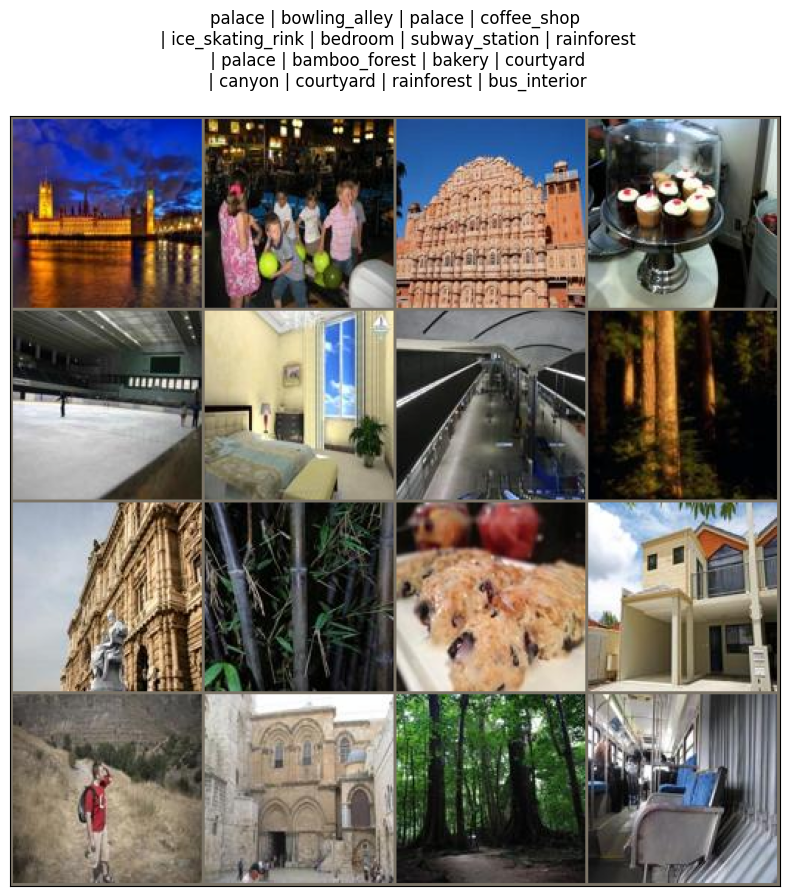

In [7]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## 5.1 (b): Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__



In [8]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [9]:
# Network configurations for all layers before the final fully-connected layers.
# "M" corresponds to maxpooling layer, integers correspond to number of output
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    """
    Return a nn.Sequential object containing all layers to get the features
    using the CNN. (That is, before the Average pooling layer in the two
    pictures above).

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer
                  should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction
                layers. For use of torch.nn.Sequential, please refer to
                PyTorch documentation.
    """
    ###########################################################################
    # TODO: Construct the neural net architecture from cfg. You should use    #
    # nn.Sequential().                                                        #
    ###########################################################################
    layers = []
    in_channels = 3
    for i in cfg:
        if i == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, i, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(i), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = i
    features = nn.Sequential(*layers)


    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        #######################################################################
        # TODO: Construct the final FC layers using nn.Sequential.            #
        # Note: The average pooling layer has been defined by us above.       #
        #######################################################################
        self.classifier = nn.Sequential(
            nn.Linear(3200, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [10]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with
# the one given in the instructions above.
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## 5.1 (c): Build training/validation loops

You will write a function for training and validating the network.

In [11]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss.
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [12]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the  outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             #
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################

                # Parameter gradients are set to zero
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get the predicted class (max score along the 1st dimension)
                    loss = criterion(outputs, labels)  # Compute the loss

                    # Backpropagation and optimization - training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained
                # weights.
                # You should download the trained weights to your local machine.
                # Later, you can load these weights directly without needing to
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)

    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## 5.1 (d): Train MiniVGG / MiniVGG-BN

In [13]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [14]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

Epoch 0/19
----------


100%|██████████| 704/704 [01:17<00:00,  9.09it/s]


train Loss: 4.5313 Acc: 0.0168


100%|██████████| 79/79 [00:07<00:00, 11.22it/s]


val Loss: 4.3003 Acc: 0.0344
Epoch 1/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.70it/s]


train Loss: 4.0851 Acc: 0.0638


100%|██████████| 79/79 [00:07<00:00, 11.23it/s]


val Loss: 3.9040 Acc: 0.0924
Epoch 2/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.54it/s]


train Loss: 3.7766 Acc: 0.1107


100%|██████████| 79/79 [00:06<00:00, 11.52it/s]


val Loss: 3.6288 Acc: 0.1347
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 3.5486 Acc: 0.1496


100%|██████████| 79/79 [00:07<00:00, 10.54it/s]


val Loss: 3.4656 Acc: 0.1636
Epoch 4/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.41it/s]


train Loss: 3.3721 Acc: 0.1796


100%|██████████| 79/79 [00:06<00:00, 11.42it/s]


val Loss: 3.2280 Acc: 0.2001
Epoch 5/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.76it/s]


train Loss: 3.2254 Acc: 0.2038


100%|██████████| 79/79 [00:07<00:00, 10.02it/s]


val Loss: 3.1424 Acc: 0.2274
Epoch 6/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.78it/s]


train Loss: 3.0975 Acc: 0.2271


100%|██████████| 79/79 [00:08<00:00,  9.57it/s]


val Loss: 3.0872 Acc: 0.2352
Epoch 7/19
----------


100%|██████████| 704/704 [01:15<00:00,  9.34it/s]


train Loss: 2.9855 Acc: 0.2504


100%|██████████| 79/79 [00:07<00:00, 10.82it/s]


val Loss: 2.9360 Acc: 0.2586
Epoch 8/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.57it/s]


train Loss: 2.8714 Acc: 0.2718


100%|██████████| 79/79 [00:07<00:00, 10.62it/s]


val Loss: 2.8654 Acc: 0.2794
Epoch 9/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 2.7754 Acc: 0.2921


100%|██████████| 79/79 [00:08<00:00,  9.71it/s]


val Loss: 2.8031 Acc: 0.2914
Epoch 10/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.72it/s]


train Loss: 2.6747 Acc: 0.3121


100%|██████████| 79/79 [00:08<00:00,  9.60it/s]


val Loss: 2.8003 Acc: 0.2974
Epoch 11/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.86it/s]


train Loss: 2.5869 Acc: 0.3292


100%|██████████| 79/79 [00:08<00:00,  9.54it/s]


val Loss: 2.7297 Acc: 0.3048
Epoch 12/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.61it/s]


train Loss: 2.4968 Acc: 0.3501


100%|██████████| 79/79 [00:08<00:00,  9.69it/s]


val Loss: 2.7650 Acc: 0.3058
Epoch 13/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.86it/s]


train Loss: 2.4136 Acc: 0.3645


100%|██████████| 79/79 [00:08<00:00,  9.63it/s]


val Loss: 2.7209 Acc: 0.3135
Epoch 14/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.62it/s]


train Loss: 2.3256 Acc: 0.3826


100%|██████████| 79/79 [00:08<00:00,  9.60it/s]


val Loss: 2.7527 Acc: 0.3140
Epoch 15/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.77it/s]


train Loss: 2.2392 Acc: 0.4019


100%|██████████| 79/79 [00:08<00:00,  9.62it/s]


val Loss: 2.7182 Acc: 0.3219
Epoch 16/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 2.1628 Acc: 0.4176


100%|██████████| 79/79 [00:08<00:00,  9.81it/s]


val Loss: 2.6940 Acc: 0.3273
Epoch 17/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.75it/s]


train Loss: 2.0808 Acc: 0.4329


100%|██████████| 79/79 [00:08<00:00,  9.49it/s]


val Loss: 2.7195 Acc: 0.3257
Epoch 18/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.59it/s]


train Loss: 2.0048 Acc: 0.4490


100%|██████████| 79/79 [00:08<00:00,  9.60it/s]


val Loss: 2.8554 Acc: 0.3186
Epoch 19/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 1.9370 Acc: 0.4634


100%|██████████| 79/79 [00:08<00:00,  9.63it/s]

val Loss: 2.8225 Acc: 0.3142
Best val Acc: 0.327300


In [15]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

Epoch 0/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.66it/s]


train Loss: 4.2152 Acc: 0.0466


100%|██████████| 79/79 [00:08<00:00,  9.73it/s]


val Loss: 3.8209 Acc: 0.0927
Epoch 1/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.73it/s]


train Loss: 3.6234 Acc: 0.1283


100%|██████████| 79/79 [00:08<00:00,  9.56it/s]


val Loss: 3.5470 Acc: 0.1438
Epoch 2/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.62it/s]


train Loss: 3.3505 Acc: 0.1739


100%|██████████| 79/79 [00:07<00:00, 10.20it/s]


val Loss: 3.2948 Acc: 0.1835
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 3.1839 Acc: 0.2077


100%|██████████| 79/79 [00:07<00:00,  9.94it/s]


val Loss: 3.1044 Acc: 0.2234
Epoch 4/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.85it/s]


train Loss: 3.0502 Acc: 0.2309


100%|██████████| 79/79 [00:07<00:00,  9.97it/s]


val Loss: 3.0661 Acc: 0.2383
Epoch 5/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.88it/s]


train Loss: 2.9499 Acc: 0.2525


100%|██████████| 79/79 [00:07<00:00,  9.95it/s]


val Loss: 2.9357 Acc: 0.2584
Epoch 6/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.72it/s]


train Loss: 2.8552 Acc: 0.2711


100%|██████████| 79/79 [00:07<00:00, 10.27it/s]


val Loss: 2.8746 Acc: 0.2632
Epoch 7/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.96it/s]


train Loss: 2.7742 Acc: 0.2885


100%|██████████| 79/79 [00:08<00:00,  9.81it/s]


val Loss: 2.7885 Acc: 0.2869
Epoch 8/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.88it/s]


train Loss: 2.6973 Acc: 0.3039


100%|██████████| 79/79 [00:08<00:00,  9.77it/s]


val Loss: 2.8014 Acc: 0.2895
Epoch 9/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.94it/s]


train Loss: 2.6280 Acc: 0.3186


100%|██████████| 79/79 [00:08<00:00,  9.86it/s]


val Loss: 2.8135 Acc: 0.2936
Epoch 10/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 2.5606 Acc: 0.3328


100%|██████████| 79/79 [00:08<00:00,  9.68it/s]


val Loss: 2.7462 Acc: 0.3060
Epoch 11/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.91it/s]


train Loss: 2.4992 Acc: 0.3462


100%|██████████| 79/79 [00:08<00:00,  9.76it/s]


val Loss: 2.6142 Acc: 0.3295
Epoch 12/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.91it/s]


train Loss: 2.4357 Acc: 0.3599


100%|██████████| 79/79 [00:08<00:00,  9.81it/s]


val Loss: 2.6116 Acc: 0.3330
Epoch 13/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 2.3745 Acc: 0.3718


100%|██████████| 79/79 [00:07<00:00, 10.01it/s]


val Loss: 2.5690 Acc: 0.3424
Epoch 14/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.79it/s]


train Loss: 2.3218 Acc: 0.3828


100%|██████████| 79/79 [00:08<00:00,  9.74it/s]


val Loss: 2.5568 Acc: 0.3434
Epoch 15/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.97it/s]


train Loss: 2.2565 Acc: 0.3967


100%|██████████| 79/79 [00:07<00:00,  9.93it/s]


val Loss: 2.4909 Acc: 0.3621
Epoch 16/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.00it/s]


train Loss: 2.2018 Acc: 0.4104


100%|██████████| 79/79 [00:07<00:00, 10.43it/s]


val Loss: 2.5923 Acc: 0.3384
Epoch 17/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.80it/s]


train Loss: 2.1412 Acc: 0.4230


100%|██████████| 79/79 [00:07<00:00, 10.70it/s]


val Loss: 2.5185 Acc: 0.3566
Epoch 18/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.66it/s]


train Loss: 2.0824 Acc: 0.4350


100%|██████████| 79/79 [00:06<00:00, 11.36it/s]


val Loss: 2.5122 Acc: 0.3555
Epoch 19/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.78it/s]


train Loss: 2.0320 Acc: 0.4456


100%|██████████| 79/79 [00:06<00:00, 11.61it/s]

val Loss: 2.5043 Acc: 0.3592
Best val Acc: 0.362100


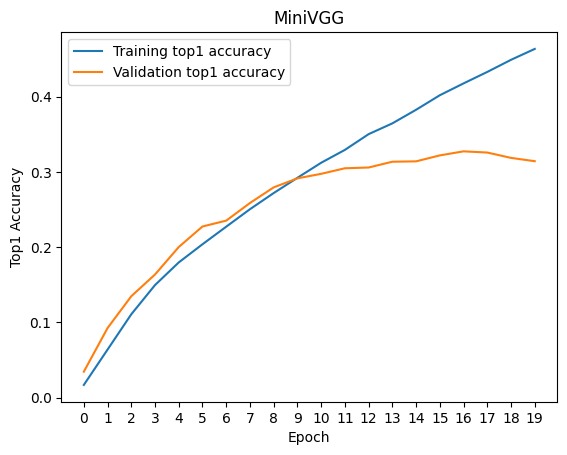

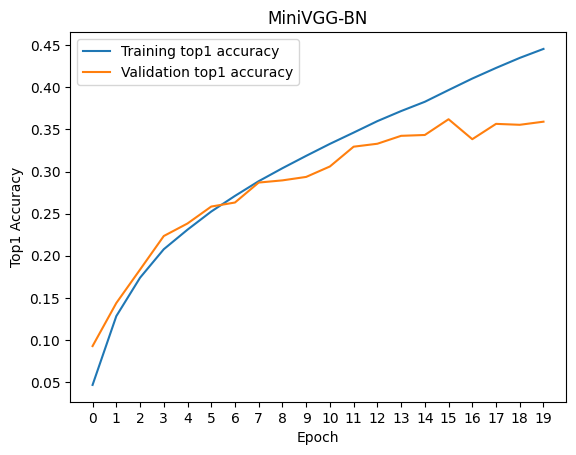

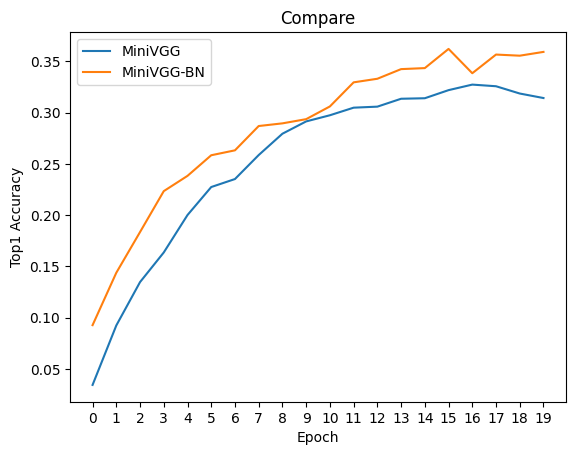

In [16]:
x = np.arange(num_epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, torch.tensor(tr_his_BN, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

### TODO: __Summarize the effect of batch normalization:__






We observed during training that MiniVGG has a tendency to overfit the data when batch normalization is not used. Its validation accuracy continuously falls short of its training accuracy, indicating poor generalization to new data. Additionally, the training accuracy varies more, probably as a result of internal normalization not taking place during the learning process. However, MiniVGG-BN (with batch normalization) exhibits more consistent performance. Better generalization is indicated by its smoother learning curves and higher validation accuracy. By stabilizing the training, batch normalization aids in accelerating the model's convergence and lowering overfitting.

In [17]:
pickle.dump(tr_his, open('tr_his.pkl', 'wb'))
pickle.dump(tr_his_BN, open('tr_his_BN.pkl', 'wb'))
pickle.dump(val_his, open('val_his.pkl', 'wb'))
pickle.dump(val_his_BN, open('val_his_BN.pkl', 'wb'))

## Step 6. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [18]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values
    of k.

    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.

    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [19]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

<ipython-input-19-2c1b30cf8121>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
<ipython-input-19-2c1b30cf812

Top-1 accuracy 35.93%, Top-5 accuracy 66.79%
Top-1 accuracy 32.65%, Top-5 accuracy 62.4%


## 5.2 (a-b): Build small ResNet model (Optional)

Please follow this figure to build the Residual Block and the Resnet model. We already implemented the back bone of the resnet model. You have to code the ResNet Block and the classifier part which are shown in the figure.

__ResNet architecture__





In [20]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        ###########################################################################
        # TODO: Code the residual block as depicted in the above figure. You should use    #
        # nn.Sequential().                                                        #
        ###########################################################################




        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

    def forward(self, x):

        ###########################################################################
        # TODO: Code the forward pass for the residual block as depicted in the above figure.
        # Note: The relu activation function is after the skip connection.                                                        #
        ###########################################################################




        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################
        return out

In [1]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '/content/drive/My Drive/Colab_Notebooks/maithreyan_PS5.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')

Mounted at /content/drive/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,031 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,378 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/u

FileNotFoundError: Cannot find file: /content/drive/My Drive/Colab_Notebooks/maithreyan_PS5.pdf